In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ga
from ga import *
from tradingrule_changelogr import *

import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data preprocessing

In [32]:
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

,Open,High,Low,Close
0,0.70613,0.70613,0.70575,0.70575
1,0.70575,0.70579,0.70568,0.70579
2,0.70579,0.70598,0.70578,0.70595
3,0.70596,0.70618,0.70594,0.70618
4,0.70618,0.70628,0.70593,0.70595


In [33]:
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

In [34]:
# %%time
# trading_rule_params = trainTradingRuleFeatures(X_train)

Training Rule1 score is: 0.298
Training Rule2 score is: 0.298
Training Rule3 score is: 0.320
Training Rule4 score is: 0.299
Training Rule5 score is: 0.278
Training Rule6 score is: 0.316
Training Rule7 score is: 0.325
Training Rule8 score is: 0.262
Training Rule9 score is: 0.320
Training Rule10 score is: 0.326
Training Rule11 score is: 0.257
Training Rule12 score is: 0.324
Training Rule13 score is: 0.257
Training Rule14 score is: 0.170
Training Rule15 score is: 0.123
Training Rule16 score is: 0.084
CPU times: user 3min 7s, sys: 3.79 s, total: 3min 10s
Wall time: 3min


### GridSearch结果保持一致，所以直接保存下来用就好，换了新数据只用算一次

In [43]:
# # Dumps the rule parameters
# params_json = json.dumps(trading_rule_params)
# with open("trading_rule_params.json", "w") as jsonFile:
#     jsonFile.write(params_json)
#     jsonFile.close()

In [47]:
# Read the rule parameters
with open("trading_rule_params.json", "r") as jsonFile:
    trading_rule_params = json.load(jsonFile)
    print(trading_rule_params)

[[1, 3], [1, 3], [1, 3], [3, 3], [1, 7], [3, 3], [3, 41], [1, 7], [1, 3], [3, 55], [3, 0], [3, 55, 50], [3, 20, 0], 11, 3, 27]


In [48]:
%%time
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

CPU times: user 3.69 s, sys: 24.5 ms, total: 3.72 s
Wall time: 3.67 s


### Genetic Algorithm to Find the Optimal Combination of Rules

In [49]:
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean postiion is {:3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))

### 思考下为什么原版代码的曲线会突然就往下打下去，SSR应该是maximize优化
### 但是现有代码居然效果更好了，比较confused, 思考下原因，注意分析到底有没有未来函数
### 跑几遍结果不一样，就不稳定，还是要分析原因

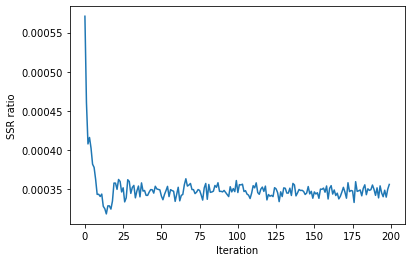

CPU times: user 34 s, sys: 1.76 s, total: 35.7 s
Wall time: 35.7 s


In [50]:
%%time
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, sol_per_pop=10, num_parents_mating=6, num_generations = 200)

In [51]:
position = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position /= np.max(abs(position))
print('Training data evaluation:')
evaluate(position, X_trading_rule_train.logr)
port_r_train = X_trading_rule_train.logr*position

Training data evaluation:
The maximum position is 0.851, the mean postiion is 0.435122.
The return over the period is: 15.92%
Maximum drawdown is: -0.551%
SR ratio is: 9.183


In [52]:
position = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position /= np.max(abs(position))
print('Testing data evaluation:')
evaluate(position, X_trading_rule_test.logr)
port_r_test = X_trading_rule_test.logr*position

Testing data evaluation:
The maximum position is 0.701, the mean postiion is 0.420240.
The return over the period is: 7.65%
Maximum drawdown is: -0.092%
SR ratio is: 5.783


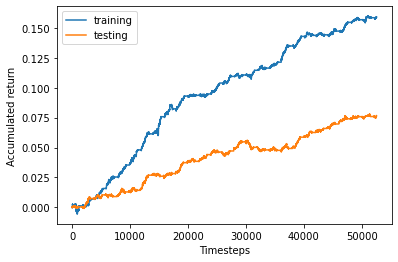

In [53]:
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.show()